In [1]:
import pandas as pd
from typing import List
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew, kurtosis
from datetime import datetime
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
import gower
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
)
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

logging.basicConfig(
    filename="simulation.log", level=logging.INFO, format="%(asctime)s %(message)s"
)


def load_dataset(filepath: str) -> pd.DataFrame:
    logging.info("Loading dataset from %s", filepath)
    df = pd.read_csv(filepath)
    logging.info("Dataset loaded successfully")
    return df

def generate_synthetic_datasets(
    df: pd.DataFrame, target_variable: str, n: int = 10
) -> List[pd.DataFrame]:
    logging.info("Generating synthetic datasets")
    synthetic_datasets = []
    X = df.drop(target_variable, axis=1)
    y = df[target_variable]

    # Create a boolean mask indicating which features are categorical
    categorical_features_mask = X.dtypes == "object"

    # Get the continuous features columns (where the mask is False)
    continuous_features_columns = X.columns[~categorical_features_mask]

    # Calculate the standard deviation of each continuous feature
    continuous_features_std = X[continuous_features_columns].std()

    for _ in range(n):
        smote_nc = SMOTENC(
            categorical_features=categorical_features_mask.tolist(),
            random_state=np.random.randint(0, 100),
        )
        X_synthetic, y_synthetic = smote_nc.fit_resample(X, y)

        # Add Gaussian noise to the continuous features, scaled by their standard deviation
        for feature in continuous_features_columns:
            X_synthetic[feature] += np.random.normal(
                0,
                0.01 * continuous_features_std[feature],
                size=X_synthetic[feature].shape,
            )

        synthetic_df = pd.concat([X_synthetic, y_synthetic], axis=1)
        synthetic_datasets.append(synthetic_df)
    logging.info("Synthetic datasets generated successfully")
    return synthetic_datasets


def generate_metadata(df: pd.DataFrame, metadata: dict) -> dict:
    logging.info("Generating metadata...")
    num_samples, num_features = df.shape
    metadata["dataset_specific_metadata"]["num_samples"] = num_samples
    features = []

    for column in df.columns:
        feature = {
            "feature_name": column,
            "feature_type": "categorical"
            if df[column].dtype.name == "category" or df[column].dtype.name == "object"
            else "continuous",
            "data_type": df[column].dtype.name,
            "feature_description": f"Description of {column}",
            "missing_values_proportion": df[column].isna().mean(),
        }

        if feature["feature_type"] == "continuous":
            feature["mean"] = df[column].mean()
            feature["median"] = df[column].median()
            feature["std_dev"] = df[column].std()
            feature["skewness"] = df[column].skew()
            feature["kurtosis"] = df[column].kurt()
        else:
            feature["categories"] = df[column].unique().tolist()
            feature["category_counts"] = df[column].value_counts().to_dict()

        features.append(feature)

    metadata["dataset_specific_metadata"]["features"] = features
    logging.info("Metadata generated.")

    return metadata


def gower_distance_matrix(df: pd.DataFrame) -> np.ndarray:
    logging.info("Calculating Gower distance matrix...")
    gower_distance = gower.gower_matrix(df)
    logging.info("Gower distance matrix calculated.")
    return gower_distance


def calculate_gower_similarity(metadata1: dict, metadata_list: list) -> np.ndarray:
    logging.info("Calculating Gower similarity...")
    features1 = metadata1["dataset_specific_metadata"]["features"]
    df1 = pd.DataFrame(features1)
    gower_similarity_scores = []

    for metadata2 in metadata_list:
        features2 = metadata2["dataset_specific_metadata"]["features"]
        df2 = pd.DataFrame(features2)

        df = pd.concat([df1, df2], axis=0)
        df.reset_index(drop=True, inplace=True)

        # Normalize numerical features
        num_features = [
            "mean",
            "median",
            "std_dev",
            "skewness",
            "kurtosis",
            "missing_values_proportion",
        ]
        scaler = MinMaxScaler()
        df[num_features] = scaler.fit_transform(df[num_features])
        df = df.fillna(0)

        gower_distance = gower_distance_matrix(df)
        gower_similarity = 1 - gower_distance[: len(df1), len(df1) :]
        # print(gower_similarity)
        gower_similarity_scores.append(np.median(gower_similarity))
        logging.info("Gower similarity calculated.")

    return np.array(gower_similarity_scores)

In [4]:
dataset_path = "/Users/irfankaradeniz/Downloads/heart.csv"
loaded_dataset = load_dataset(dataset_path)

# Step 2: Generate metadata of the loaded dataset
metadata_schema = pd.read_json("metadata_schema_small.json")
loaded_dataset_metadata = generate_metadata(loaded_dataset, metadata_schema)

In [5]:
loaded_dataset_metadata

,dataset_id,dataset_name,dataset_description,creation_time,last_modified_time,dataset_version,submission_set,dataset_specific_metadata
submission_id,unique_dataset_identifier,short_descriptive_name,longer_description_of_dataset,timestamp,timestamp,version_number,unique_submission_id,NaN
submission_time,unique_dataset_identifier,short_descriptive_name,longer_description_of_dataset,timestamp,timestamp,version_number,timestamp,NaN
num_samples,unique_dataset_identifier,short_descriptive_name,longer_description_of_dataset,timestamp,timestamp,version_number,NaN,918
features,unique_dataset_identifier,short_descriptive_name,longer_description_of_dataset,timestamp,timestamp,version_number,NaN,"[{'feature_name': 'Age', 'feature_type': 'cont..."


In [6]:
# Step 3: Generate 10 synthetic datasets similar to the one we read
target_variable = "HeartDisease"
synthetic_datasets = generate_synthetic_datasets(
    loaded_dataset, target_variable, n=10
)

# Step 4: Generate metadata for each of the datasets
synthetic_datasets_metadata_list = [
    generate_metadata(df, metadata_schema.copy()) for df in synthetic_datasets
]

In [15]:
loaded_dataset['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [8]:
synthetic_datasets[0].head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,39.985807,M,ATA,139.857710,289.320357,0.000916,Normal,172.325272,N,0.009245,Up,0
1,49.018254,F,NAP,159.900462,179.674965,-0.007526,Normal,156.314698,N,1.006342,Flat,1
2,37.013788,M,ATA,129.847853,281.825813,-0.006695,ST,97.699194,N,0.025071,Up,0
3,47.937868,F,ASY,137.638311,214.455071,0.003054,Normal,107.915877,Y,1.489659,Flat,1
4,54.040182,M,NAP,150.080682,193.900599,-0.000825,Normal,122.132927,N,0.014740,Up,0


In [14]:
synthetic_datasets[3]['HeartDisease'].value_counts()

HeartDisease
0    508
1    508
Name: count, dtype: int64

In [19]:
gower_similarity_scores = calculate_gower_similarity(
    loaded_dataset_metadata, synthetic_datasets_metadata_list
)
most_similar_index = np.argmax(gower_similarity_scores)
most_similar_dataset = synthetic_datasets[most_similar_index]



In [20]:
most_similar_dataset

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,39.985807,M,ATA,139.857710,289.320357,0.000916,Normal,172.325272,N,0.009245,Up,0
1,49.018254,F,NAP,159.900462,179.674965,-0.007526,Normal,156.314698,N,1.006342,Flat,1
2,37.013788,M,ATA,129.847853,281.825813,-0.006695,ST,97.699194,N,0.025071,Up,0
3,47.937868,F,ASY,137.638311,214.455071,0.003054,Normal,107.915877,Y,1.489659,Flat,1
4,54.040182,M,NAP,150.080682,193.900599,-0.000825,Normal,122.132927,N,0.014740,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1011,45.027338,M,NAP,140.071546,192.032840,0.002614,Normal,173.785690,N,0.608498,Up,0
1012,44.014497,M,ATA,128.073437,308.810885,0.009785,Normal,167.229293,N,0.508838,Up,0
1013,51.988154,M,NAP,169.893243,197.449662,0.001595,Normal,162.481839,N,0.468835,Up,0
1014,41.902736,M,NAP,139.327157,224.951110,-0.000530,Normal,176.757108,N,0.006194,Up,0


In [23]:
def plot_histogram(original_data, synthetic_data, feature):
    plt.figure(figsize=(10,6))
    sns.histplot(original_data[feature], color='blue', label='Original', kde=True)
    sns.histplot(synthetic_data[feature], color='red', label='Synthetic', kde=True)
    plt.title(f'Histogram for {feature}')
    plt.legend()
    plt.show()

def plot_boxplot(original_data, synthetic_data, feature):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=[original_data[feature], synthetic_data[feature]], notch=True)
    plt.xticks([0, 1], ['Original', 'Synthetic'])
    plt.title(f'Boxplot for {feature}')
    plt.show()

def plot_barplot(original_data, synthetic_data, feature):
    fig, ax = plt.subplots(2, 1, figsize=(10,12))

    sns.countplot(x=feature, data=original_data, ax=ax[0], color='blue')
    ax[0].set_title(f'Barplot for {feature} in Original Data')
    ax[0].set_ylabel('Count')

    sns.countplot(x=feature, data=synthetic_data, ax=ax[1], color='red')
    ax[1].set_title(f'Barplot for {feature} in Synthetic Data')
    ax[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    
def visualize_features(original_data, synthetic_data):
    for feature in original_data.columns:
        if original_data[feature].dtype in ['int64', 'float64']:
            # For numeric features, use histogram and boxplot
            plot_histogram(original_data, synthetic_data, feature)
            plot_boxplot(original_data, synthetic_data, feature)
        else:
            # For categorical features, use barplot
            plot_barplot(original_data, synthetic_data, feature)

In [25]:
# visualize_features(loaded_dataset, most_similar_dataset)

In [37]:
def visualize_gower_similarity(
    loaded_dataset, synthetic_datasets, gower_similarity_scores
):
    logging.info("Starting visualization of Gower's similarity scores...")

    # Reshape gower_similarity_scores to a 2D array
    gower_similarity_scores = gower_similarity_scores.reshape(-1, 1)

    # Heatmap of Gower's similarity matrix
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        gower_similarity_scores,
        annot=True,
        cmap="coolwarm",
        fmt='.10g',  
        cbar=False,
        xticklabels=False,
    )
    plt.title("Heatmap of Gower's Similarity Matrix")
    plt.ylabel("Original Dataset")
    plt.xlabel("Synthetic Datasets")
    plt.show()

    # #Comparison of distributions
    # most_similar_index = gower_similarity_scores.argmax()
    # most_similar_dataset = synthetic_datasets[most_similar_index]

    # num_features = len(loaded_dataset.columns) - 1
    # fig, axes = plt.subplots(
    #     num_features, 2, figsize=(12, 4 * num_features), sharex="col"
    # )

    # for idx, feature in enumerate(loaded_dataset.columns[:-1]):
    #     sns.histplot(loaded_dataset[feature], ax=axes[idx, 0], kde=True, color="blue")
    #     sns.histplot(
    #         most_similar_dataset[feature], ax=axes[idx, 1], kde=True, color="green"
    #     )
    #     axes[idx, 0].set_title(f"Original Dataset: {feature}")
    #     axes[idx, 1].set_title(f"Most Similar Dataset: {feature}")

    # plt.tight_layout()
    # plt.show()

    # # Scatterplot matrix
    # combined_data = loaded_dataset.append(most_similar_dataset)
    # combined_data["dataset"] = ["Original"] * len(loaded_dataset) + ["Synthetic"] * len(
    #     most_similar_dataset
    # )
    # sns.pairplot(combined_data, hue="dataset", diag_kind="hist", corner=True)
    # plt.suptitle(
    #     "Scatterplot Matrix Comparing Original and Most Similar Synthetic Datasets",
    #     y=1.02,
    # )
    # plt.show()

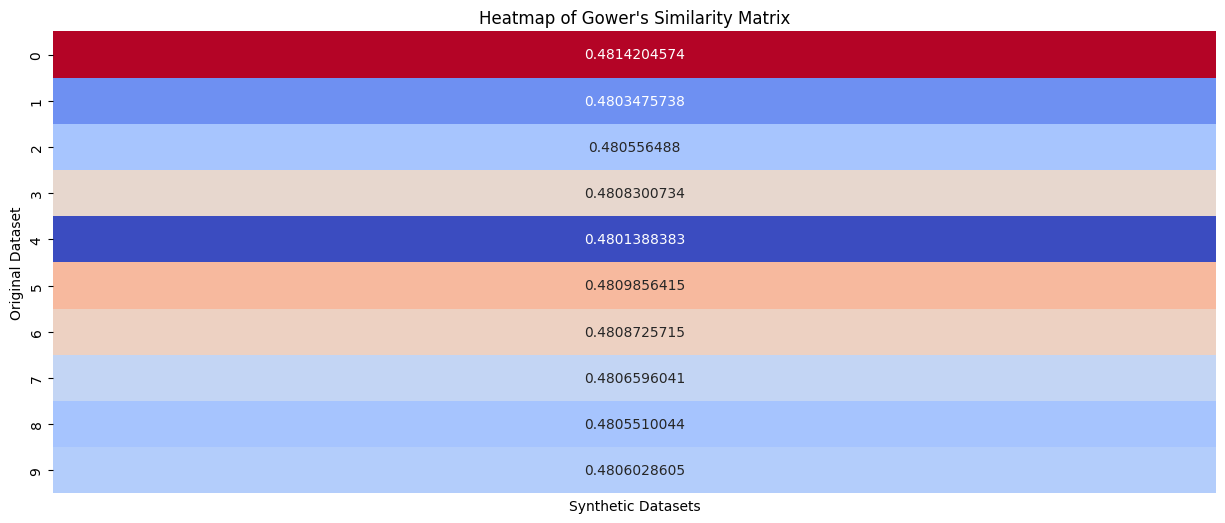

In [38]:
visualize_gower_similarity(
    loaded_dataset, synthetic_datasets, gower_similarity_scores
)

In [66]:
def train_test_split_with_encoding(
    df, target_variable, test_size=0.2, random_state=None
):
    logging.info("Performing train-test split and encoding...")
    X = df.drop(target_variable, axis=1)
    y = df[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    X_train_encoded = pd.get_dummies(X_train)
    X_test_encoded = pd.get_dummies(X_test)

    # Ensure both train and test sets have the same columns after encoding
    X_train_encoded, X_test_encoded = X_train_encoded.align(
        X_test_encoded, join="left", axis=1, fill_value=0
    )

    logging.info("Train-test split and encoding completed.")

    return X_train_encoded, X_test_encoded, y_train, y_test


def train_and_evaluate_model_kfold(X_train, y_train, X_test, y_test, classifier):
    logging.info("Training and evaluating model...")
    clf = classifier
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    logging.info(
        "Model evaluation completed. Accuracy: %s, Recall: %s, F1: %s, Precision: %s, ROC AUC: %s",
        accuracy,
        recall,
        f1,
        precision,
        roc_auc,
    )

    return accuracy, recall, f1, precision, roc_auc


def plot_performance_metrics(
    performance_metrics_list: List[dict], metric_names: List[str]
):
    n_datasets = len(performance_metrics_list)
    n_metrics = len(metric_names)

    for metric_name in metric_names:
        metric_values = [metrics[metric_name] for metrics in performance_metrics_list]

        plt.figure(figsize=(10, 5))
        plt.bar(range(n_datasets), metric_values)
        plt.xlabel("Synthetic Dataset Index")
        plt.ylabel(metric_name.capitalize())
        plt.title(f"{metric_name.capitalize()} Across Synthetic Datasets")
        plt.xticks(range(n_datasets))
        plt.grid(True)
        plt.show()


def validate_model(
    most_similar_dataset: pd.DataFrame, target_variable: str, classifier
):
    logging.info("Validating model...")
    X_train, X_test, y_train, y_test = train_test_split_with_encoding(
        most_similar_dataset, target_variable, test_size=0.2, random_state=42
    )
    (
        accuracy,
        recall,
        f1,
        precision,
        roc_auc,
    ) = train_and_evaluate_model_kfold(X_train, y_train, X_test, y_test, classifier)

    logging.info(
        "Model validation completed. Accuracy: %s, Recall: %s, F1: %s, Precision: %s, ROC AUC: %s",
        accuracy,
        recall,
        f1,
        precision,
        roc_auc,
    )

    return {
        "accuracy": accuracy,
        "recall": recall,
        "f1": f1,
        "precision": precision,
        "roc_auc": roc_auc,
        }

In [42]:
classifiers = [
    {
        "name": "Random Forest",
        "clf": RandomForestClassifier(random_state=42),
    }
]
k = 5  # Number of folds for cross-validation
kfold = KFold(n_splits=k, random_state=42, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split_with_encoding(
    loaded_dataset, target_variable, test_size=0.2, random_state=42
)

for classifier_info in classifiers:
    logging.info(f"Testing {classifier_info['name']}")

    accuracies = []
    recalls = []
    f1_scores = []
    precisions = []
    roc_aucs = []

    for train_idx, test_idx in kfold.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        (
            accuracy,
            recall,
            f1,
            precision,
            roc_auc,
            conf_matrix,
        ) = train_and_evaluate_model_kfold(
            X_train_fold,
            y_train_fold,
            X_test_fold,
            y_test_fold,
            classifier_info["clf"],
        )

        accuracies.append(accuracy)
        recalls.append(recall)
        f1_scores.append(f1)
        precisions.append(precision)
        roc_aucs.append(roc_auc)

    # Calculate the average performance metrics
    avg_accuracy = np.mean(accuracies)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)
    avg_precision = np.mean(precisions)
    avg_roc_auc = np.mean(roc_aucs)

    # logging.info(f"{classifier_info['name']} - Trained and evaluated model using k-fold cross-validation (accuracy={avg_accuracy}, recall={avg_recall}, f1={avg_f1}, precision={avg_precision}, roc_auc={avg_roc_auc})")

    

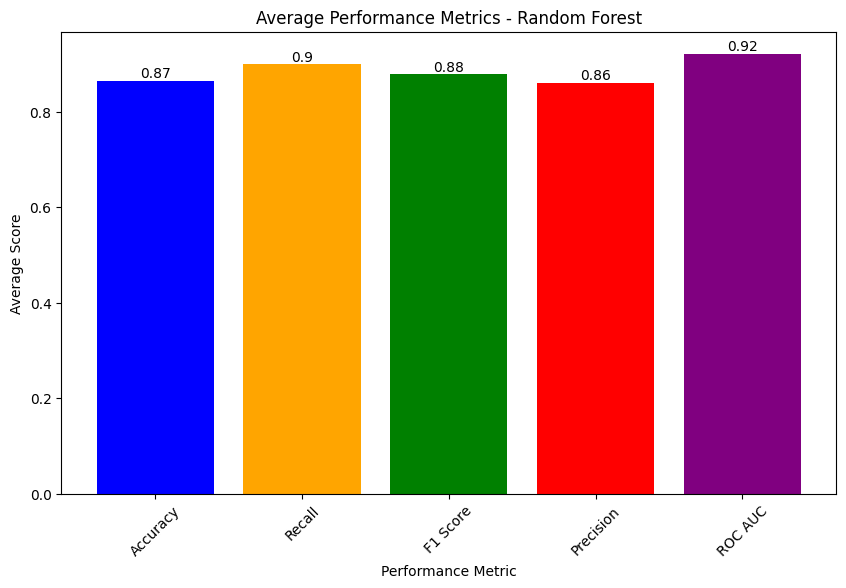

In [57]:
# Get the classifier name from the classifiers dictionary
classifier_name = classifiers[0]['name']

# Create a dictionary to store the performance metrics for each fold
metrics = {
    'Accuracy': accuracies,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'ROC AUC': roc_aucs
}

# Calculate the average performance metrics
avg_metrics = {metric_name: np.mean(metric_values) for metric_name, metric_values in metrics.items()}

# Define colors for the bars
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plot the performance metrics for each fold
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.xlabel('Performance Metric')
plt.ylabel('Average Score')
plt.title(f'Average Performance Metrics - {classifier_name}')
plt.xticks(rotation=45)

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


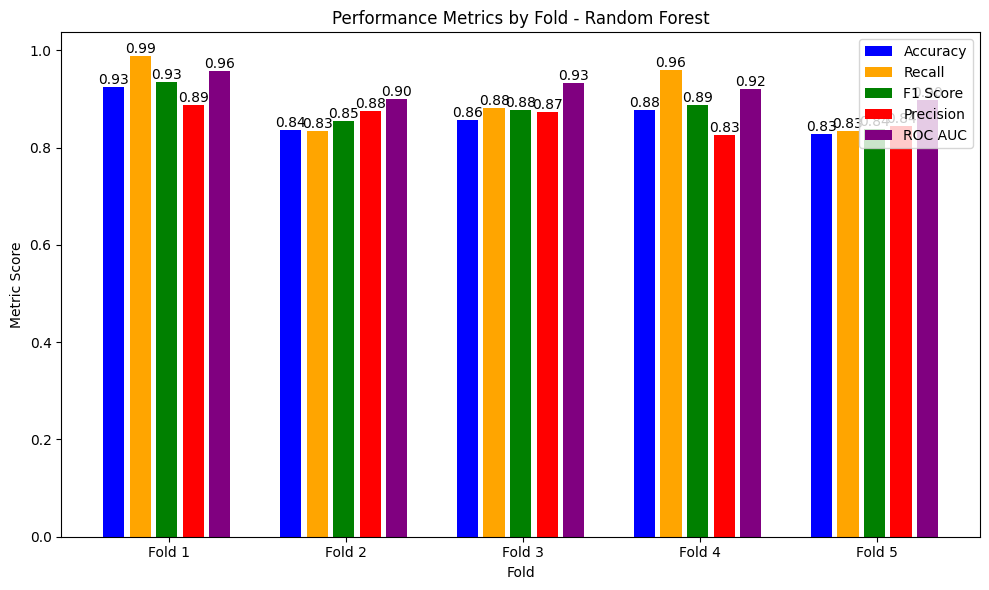

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Get the classifier name from the classifiers dictionary
classifier_name = classifiers[0]['name']

# Create a dictionary to store the performance metrics for each fold
metrics = {
    'Accuracy': accuracies,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'ROC AUC': roc_aucs
}

# Define colors for the bars
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Get the number of folds
num_folds = len(accuracies)

# Set the width of each bar
bar_width = 0.12

# Set the spacing between each group of bars
bar_spacing = 0.03

# Compute the offset for each group of bars
offsets = np.arange(len(metrics)) * (bar_width + bar_spacing)

# Plot the performance metrics for each fold
plt.figure(figsize=(10, 6))
for i, (metric_name, metric_values) in enumerate(metrics.items()):
    x = np.arange(num_folds)
    plt.bar(x + offsets[i], metric_values, width=bar_width, color=colors[i], label=metric_name)
    for j, value in enumerate(metric_values):
        plt.text(x[j] + offsets[i], value, f'{value:.2f}', ha='center', va='bottom')

plt.xlabel('Fold')
plt.ylabel('Metric Score')
plt.title(f'Performance Metrics by Fold - {classifier_name}')
plt.legend()
plt.xticks(x + (len(metrics) * bar_width + bar_spacing) / 2, [f'Fold {j+1}' for j in range(num_folds)])
plt.tight_layout()
plt.show()


In [67]:
# Step 7: Validate the model by applying the same model and thresholds to the dataset we found most similar
validation_results = validate_model(
    most_similar_dataset, target_variable, classifier_info["clf"]
)
# logging.info(f"Validation results: {validation_results}")



In [68]:
validation_results

{'accuracy': 0.8578431372549019,
 'recall': 0.896551724137931,
 'f1': 0.8776371308016878,
 'precision': 0.859504132231405,
 'roc_auc': 0.9331406739811913}

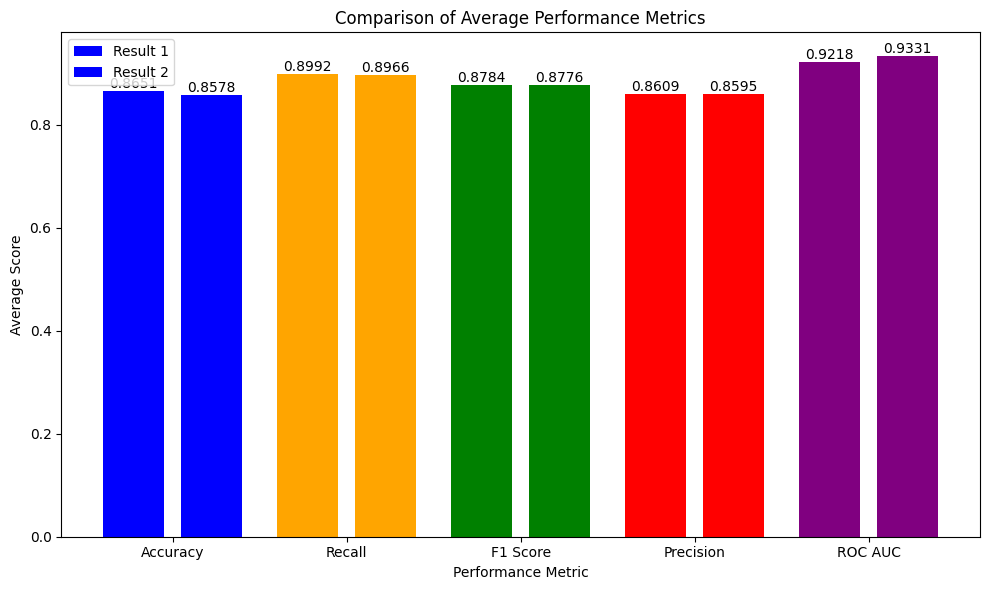

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Define the names for the two sets of results
result1_name = "Result 1"
result2_name = "Result 2"

# Define the performance metrics and their average values for each result
# Define the performance metrics and their average values for each result
result1_metrics = {
    'Accuracy': avg_accuracy,
    'Recall': avg_recall,
    'F1 Score': avg_f1,
    'Precision': avg_precision,
    'ROC AUC': avg_roc_auc
}

result2_metrics = {
    'Accuracy': validation_results['accuracy'],
    'Recall': validation_results['recall'],
    'F1 Score': validation_results['f1'],
    'Precision': validation_results['precision'],
    'ROC AUC': validation_results['roc_auc']
}

# Define colors for the bars
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Set the width of each bar
bar_width = 0.35

# Set the spacing between each metric
bar_spacing = 0.1

# Calculate the x-coordinates for the bars of result 1 and result 2
x1 = np.arange(len(result1_metrics))
x2 = x1 + bar_width + bar_spacing

# Plot the average metrics for each result
plt.figure(figsize=(10, 6))
plt.bar(x1, result1_metrics.values(), width=bar_width, color=colors[:len(result1_metrics)], label=result1_name)
plt.bar(x2, result2_metrics.values(), width=bar_width, color=colors[:len(result2_metrics)], label=result2_name)

# Add numbers on top of the bars
for i, (x, y) in enumerate(zip(x1, result1_metrics.values())):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

for i, (x, y) in enumerate(zip(x2, result2_metrics.values())):
    plt.text(x, y, f'{y:.4f}', ha='center', va='bottom')

# Adjust x-axis ticks and labels
plt.xticks(np.arange(len(result1_metrics)) + (bar_width + bar_spacing) / 2, result1_metrics.keys())
plt.xlabel('Performance Metric')
plt.ylabel('Average Score')
plt.title('Comparison of Average Performance Metrics')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 8: Train and evaluate the model on each synthetic dataset and store the metrics
performance_metrics_list = []
for synthetic_dataset in synthetic_datasets:
    X_train, X_test, y_train, y_test = train_test_split_with_encoding(
        synthetic_dataset, target_variable, test_size=0.2, random_state=42
    )
    for classifier_info in classifiers:
        logging.info(f"Testing {classifier_info['name']} on synthetic dataset")
        (
            accuracy,
            recall,
            f1,
            precision,
            roc_auc,
            conf_matrix,
        ) = train_and_evaluate_model_kfold(
            X_train, y_train, X_test, y_test, classifier_info["clf"]
        )
        metrics = {
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1,
            "precision": precision,
            "roc_auc": roc_auc,
            "conf_matrix": conf_matrix,
        }
        performance_metrics_list.append(metrics)
        
    # Step 9: Plot the performance metrics across synthetic datasets
    metric_names = ["accuracy", "recall", "f1", "precision", "roc_auc"]
    plot_performance_metrics(performance_metrics_list, metric_names)